# Libraries

In [48]:
import csv
import os
import re
import json
import umap

import hdbscan
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import matplotlib.colors
from IPython.display import clear_output
from pointgrid import align_points_to_grid

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import math
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from scipy import interpolate


# Import

## Dataset

In [49]:
# articles = pd.read_json('data/fusion.json')
articles = pd.read_json('data/service/work/fusion.json')

list_orgs = []
list_people = []
list_places = []
list_subjects = []

for index, row in articles.iterrows():

    orgs = row['NER']['ORG']
    people = row['NER']['PERSON']
    places = row['NER']['GPE']

    subjects = []
    for tag in row['tags']:
        if float(tag['score']) > .5:
            subjects.append(tag['label'])

    list_orgs.append(orgs)
    list_people.append(people)
    list_places.append(places)
    list_subjects.append(subjects)

articles['orgs'] = list_orgs
articles['people'] = list_people
articles['places'] = list_places
articles['subjects'] = list_subjects

articles = articles.drop(['tags', 'NER', 'text_content', 'index', 'article'], axis=1)

articles.sample()
len(articles)

893

## Entities

In [50]:
entities = np.empty((0, 12), dtype=object)

years_template = {}

for year in sorted(set(articles['year'].tolist())):
    years_template[year] = 0


def update(entity, type):  # Function for writing

    global entities
    co = cooccurrences.copy()
    co.remove(entity)
    index = np.where(entities[:, 0] == entity)[0]

    if index.size == 0:
        entities = np.append(
            entities,
            np.array(
                [
                    [
                        entity,
                        type,
                        1,
                        None,
                        None,
                        -1,
                        -1,
                        -1,
                        years_template.copy(),
                        [url],
                        [title],
                        co,
                    ]
                ],
                dtype=object,
            ),
            axis=0,
        )
        entities[len(entities) - 1][8][year] = 1  # Add year
    else:
        entities[index, 2] += 1  # Frequency
        entities[index, 8][0][year] += 1  # Year
        entities[index, 9][0].append(url)  # URL
        entities[index, 10][0].append(title)  # Title
        entities[index, 11][0] += co  # Co-occurrences


for index, row in articles.iterrows():  # Iteration on all the articles

    url = row["url"]
    year = row["year"]
    title = row["title"]
    cooccurrences = list(set(row["subjects"] + row["orgs"] + row["people"]))

    for entity in row["subjects"]:
        update(entity, "subject")

    for entity in row["orgs"]:
        update(entity, "org")

    for entity in row["people"]:
        update(entity, "person")

# Numpy to Pandas

entities_all = pd.DataFrame(
    entities,
    columns=[
        "name",
        "type",
        "frequency",
        "slope",
        "color",
        "x",
        "y",
        "cluster",
        "years",
        "urls",
        "titles",
        "cooccurrences",
    ],
)  # Dataset
entities_all = entities_all.astype(
    {
        "name": "str",
        "type": "str",
        "frequency": "int",
        "slope": "float",
        "color": "str",
        "x": "int",
        "y": "int",
        "cluster": "int",
        "years": "object",
        "urls": "object",
        "titles": "object",
        "cooccurrences": "object",
    }
)


print("The total number of entities is", len(entities))

entities_all.sort_values(by=["frequency"], ascending=False).head(1)


The total number of entities is 14156


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences
56,Svalbard,org,958,NaN,None,-1,-1,-1,"{2013: 0, 2015: 1, 2018: 5, 2019: 145, 2020: 2...",[https://www.inquisitr.com/5200494/nasas-visio...,[NASA’s VISIONS-2 Rockets Take To Space To Pho...,"[Cusp, GCI, Twitter, @NASASun, NASA Sun & Spac..."


# Treatment

## Normalization

In [51]:
# Frequency scale

frequency = entities_all["frequency"].to_numpy().reshape(-1, 1)
min_max_scaler = preprocessing.MinMaxScaler()
frequency_scaled = min_max_scaler.fit_transform(frequency)
entities_all["frequency_norm"] = frequency_scaled

# Transfrom dictionary into JSON

for index, row in entities_all.iterrows():
    entities_all.loc[index, "years_JSON"] = json.dumps(row["years"])

entities_all.sample(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
2811,Sara Aridi,person,2,NaN,None,-1,-1,-1,"{2013: 0, 2015: 0, 2018: 0, 2019: 0, 2020: 2, ...",[https://www.nytimes.com/2020/03/14/arts/telev...,[What’s on TV Saturday: ‘Hobbs & Shaw’ and ‘Fu...,"[Vin Diesel, Paul Walker, Caroline Rhea, Julia...",0.001045,"{""2013"": 0, ""2015"": 0, ""2018"": 0, ""2019"": 0, ""..."


## Filter

In [52]:
# Number of rows by type

# max_subjects = 1000
# max_orgs = 1000
# max_people = 1000

# top_subjects = (
#     entities_all.loc[entities_all["type"] == "subject"]
#     .sort_values(by=["frequency"], ascending=False)
#     .head(max_subjects)
# )
# top_orgs = (
#     entities_all.loc[entities_all["type"] == "org"]
#     .sort_values(by=["frequency"], ascending=False)
#     .head(max_orgs)
# )
# top_people = (
#     entities_all.loc[entities_all["type"] == "person"]
#     .sort_values(by=["frequency"], ascending=False)
#     .head(max_people)
# )

# entities = pd.concat([top_subjects, top_orgs, top_people])

min_frequency = 15

entities = (
    entities_all[entities_all['frequency']>min_frequency]
    .sort_values(by=["frequency"], ascending=False)
)

len(entities)


195

## Linear Regression

In [53]:
# for each enetity

for i, row in entities.iterrows():

    x = list(row["years"].keys())
    x = np.array(x).reshape((-1, 1))  # needed for one-column values
    y = list(row["years"].values())

    regression = LinearRegression()
    regression.fit(x, y)

    slope = regression.coef_[0] # compute linear regression
    entities.at[i, "slope"] = slope


# normalization by type

scale = 1

for type in entities["type"].unique():

    selection = entities.loc[entities["type"] == type]
    mean = selection["slope"].mean() * scale
    
    for i, row in selection.iterrows():
        entities.at[i, "slope"] = row["slope"] - mean


entities.sample(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
1993,Lee,person,23,-0.760063,None,-1,-1,-1,"{2013: 0, 2015: 0, 2018: 0, 2019: 19, 2020: 1,...",[https://ew.com/recap/his-dark-materials-seaso...,['His Dark Materials' recap: Lyra and aeronaut...,"[Kaisa, Lin-Manuel Miranda, Lauren Morgan Laur...",0.022989,"{""2013"": 0, ""2015"": 0, ""2018"": 0, ""2019"": 19, ..."


## Colors

In [54]:
import matplotlib.colors as mcolors

cmap = plt.cm.coolwarm
norm = matplotlib.colors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

for i, row in entities.iterrows():

    if row["type"] != "subject":
        entities.at[i, "color"] = mcolors.to_hex(cmap(norm(row["slope"])))  # Actors
    else:
        entities.at[i, "color"] = "#cccccc"  # Subjects

# entities.sort_values(by=["slope"], ascending=False).head(1)
entities.head(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
56,Svalbard,org,958,25.921238,#b40426,-1,-1,-1,"{2013: 0, 2015: 1, 2018: 5, 2019: 145, 2020: 2...",[https://www.inquisitr.com/5200494/nasas-visio...,[NASA’s VISIONS-2 Rockets Take To Space To Pho...,"[Cusp, GCI, Twitter, @NASASun, NASA Sun & Spac...",1.0,"{""2013"": 0, ""2015"": 1, ""2018"": 5, ""2019"": 145,..."


# Embedding

## Term Frequency

In [55]:
vectorizer = CountVectorizer(
    input="content",
    lowercase=False,
    # preprocessor=lambda x: x,
    tokenizer=lambda key: key,
)
words = entities["cooccurrences"].to_list()
X = vectorizer.fit_transform(words)

tfidf = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf.fit(X)
train_data = tfidf.transform(X)


/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


## UMAP

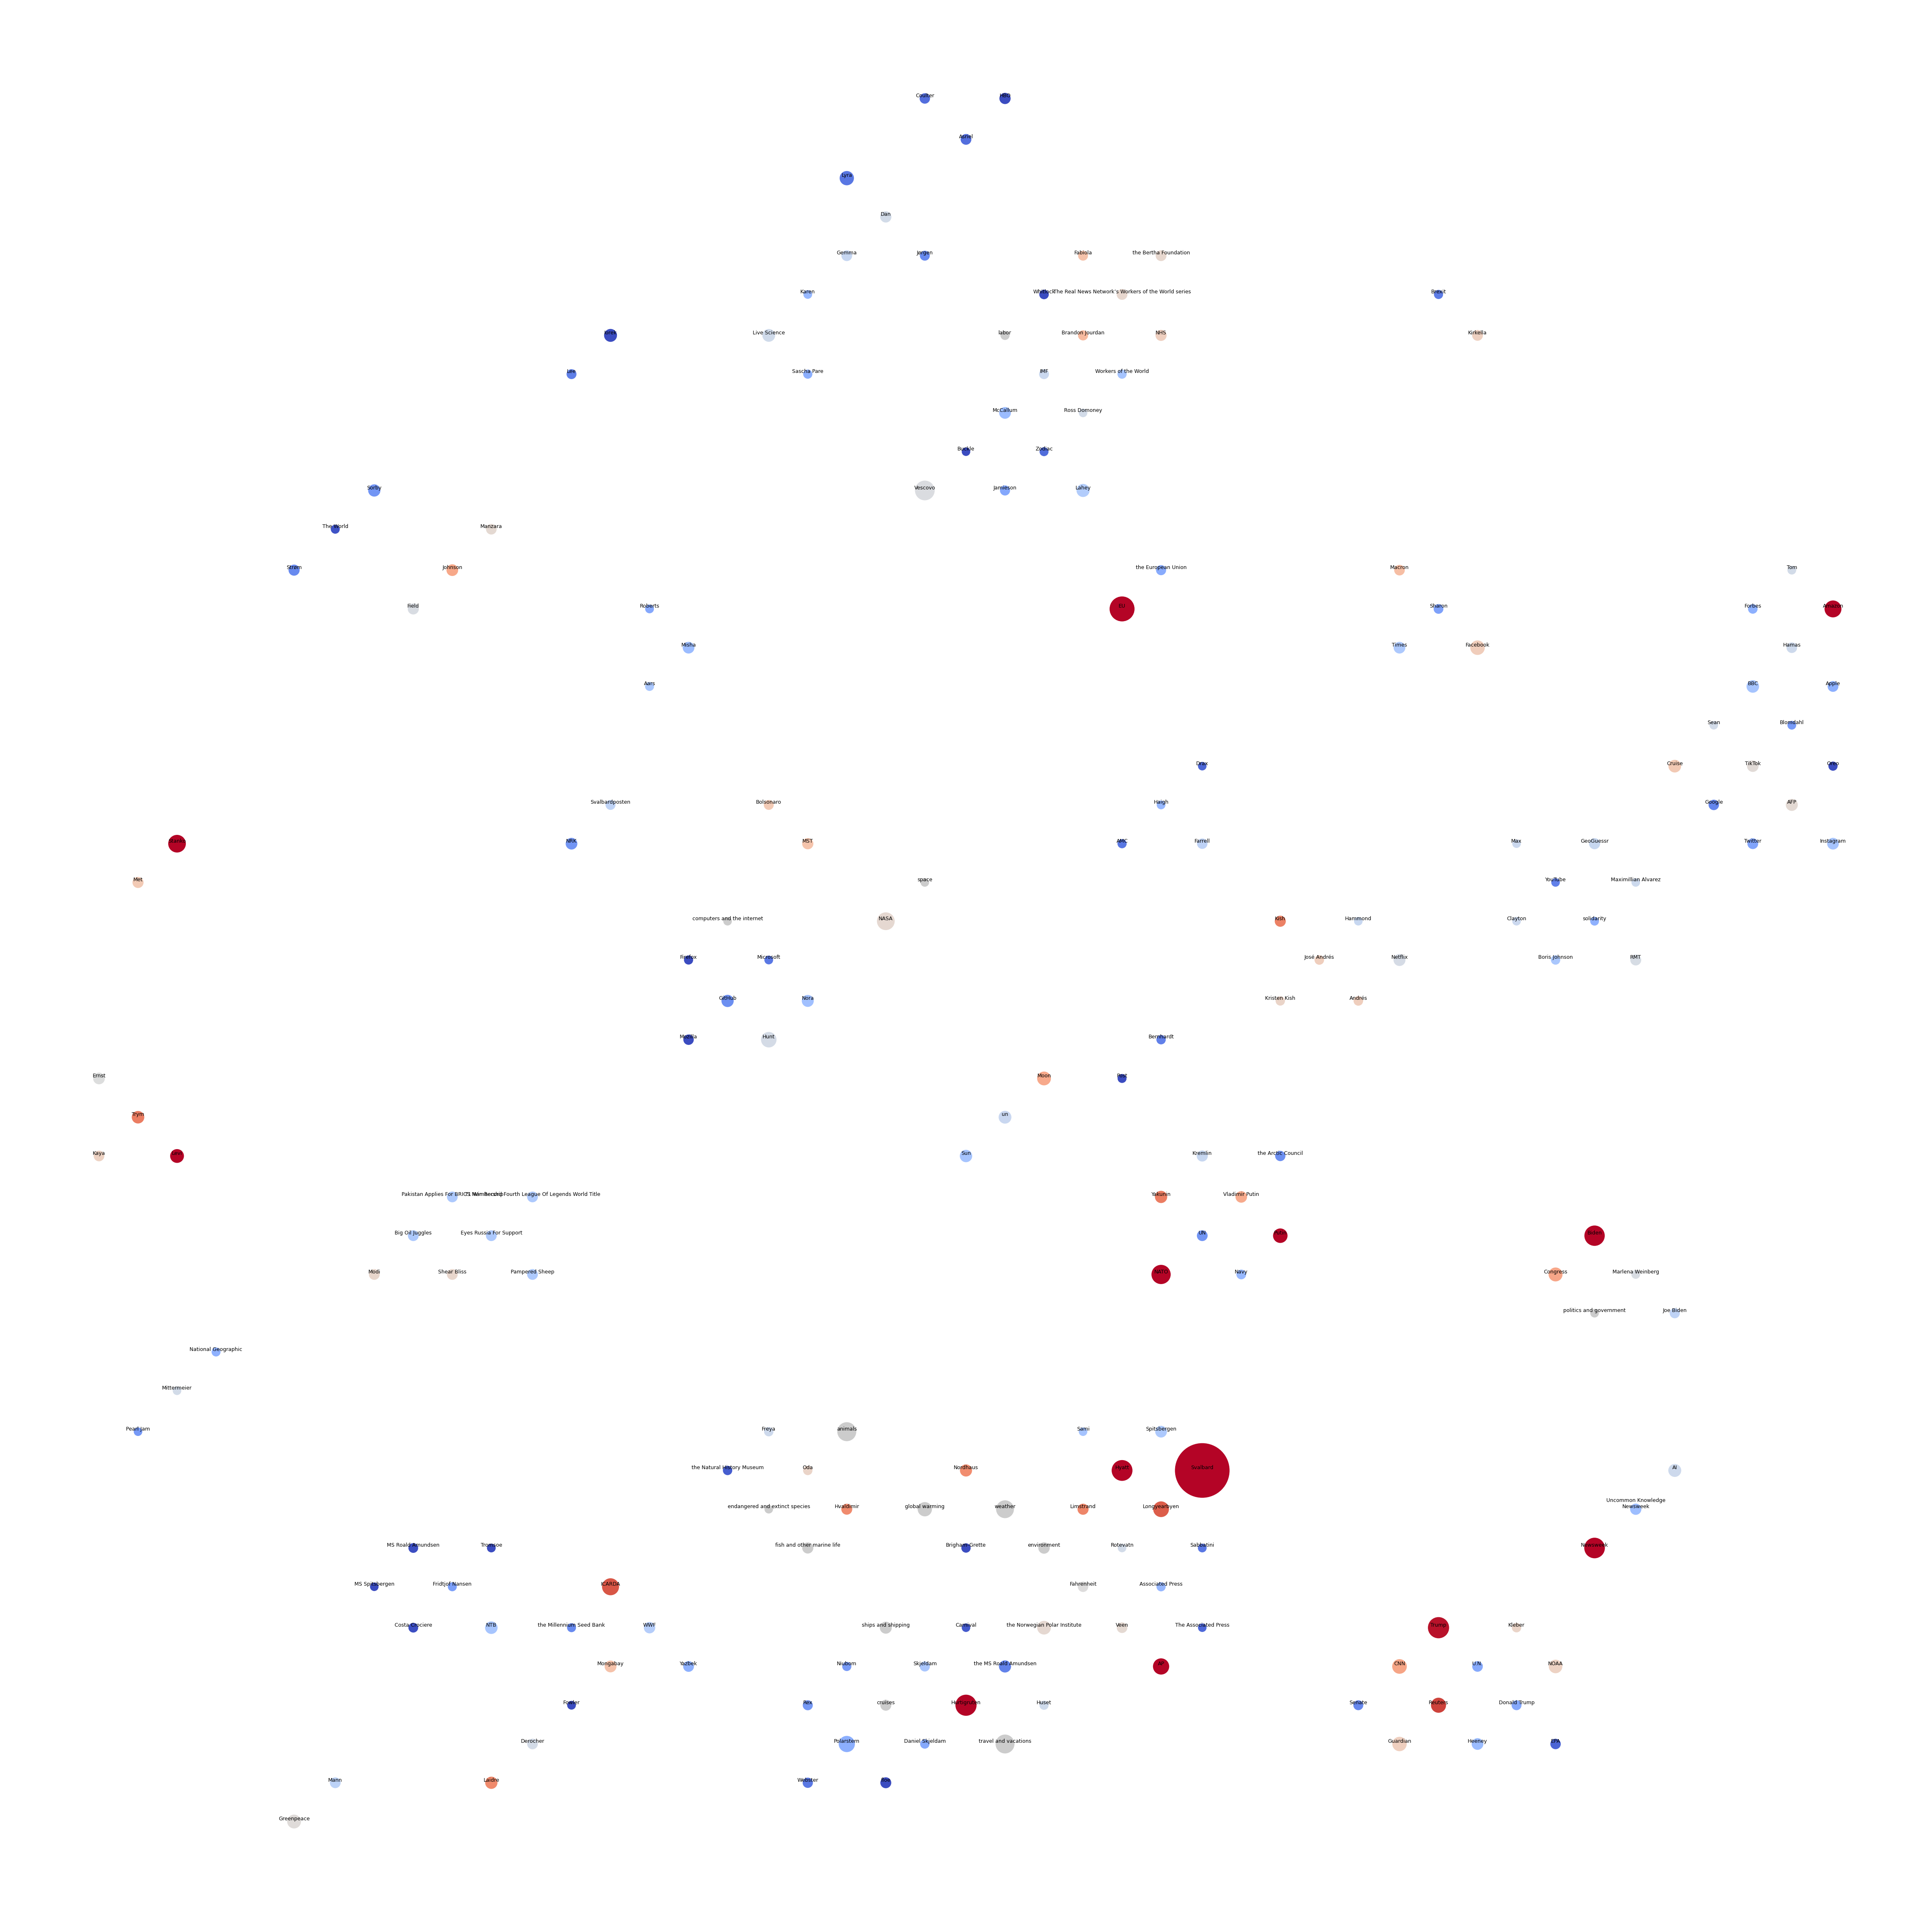

In [56]:
reducer = umap.UMAP(
    random_state=4,
    n_components=2,
    n_neighbors=2,
    min_dist=0.2,
    metric="hellinger",
)

embedding = reducer.fit_transform(train_data)  # Reducer
embedding = align_points_to_grid(embedding)  # Alignment to a grid

scaler = MinMaxScaler(feature_range=(100, 900))  # Scale
embedding = scaler.fit_transform(embedding)
embedding = embedding.astype(int)

index_embedding = 0  # Writing values in the dataset
for index, row in entities.iterrows():
    entities.loc[index, "x"] = embedding[:, 0][index_embedding]
    entities.loc[index, "y"] = embedding[:, 1][index_embedding]
    index_embedding += 1

# entities.sample(1)

plt.figure(figsize=(20, 20), dpi=300)
plt.axis("off")

# Scatterplot

plt.scatter(
    entities["x"].to_list(),
    entities["y"].to_list(),
    s=entities["frequency"].to_list(),
    c=entities["color"].to_list(),
)

# Labels

for i, row in entities.iterrows():
    text = plt.annotate(row["name"], xy=(row["x"], row["y"]), ha="center", va="bottom")
    text.set_fontsize(3)

plt.savefig("download.png")


## Clustering

In [57]:
clusterer = hdbscan.HDBSCAN(
    # min_samples=3,
    min_cluster_size=4,
    # cluster_selection_epsilon=50,   # float, optional (default=0.0) A distance threshold. Clusters below this value will be merged.
    # gen_min_span_tree=False,
    # leaf_size=10, # int, optional (default=40) If using a space tree algorithm (kdtree, or balltree) the number of points ina leaf node of the tree. This does not alter the resulting clustering, but may have an effect on the runtime of the algorithm.
)

entities["cluster"] = "-1"  # Reset


def cluster_computing(rows, prefix, entities):

    embedding = rows[["x", "y"]].to_numpy()
    clusterer.fit(embedding)
    clusters = clusterer.labels_

    # Write cluster number

    for count, (index, row) in enumerate(rows.iterrows()):
        if clusters[count] != -1:
            entities.loc[index, "cluster"] = prefix + str(clusters[count])
        else:
            entities.loc[index, "cluster"] = str(clusters[count])


cluster_computing(
    entities.loc[(entities["type"] != "subject") & (entities["slope"] > 0)],
    "p_",
    entities,
)
cluster_computing(
    entities.loc[(entities["type"] != "subject") & (entities["slope"] < 0)],
    "n_",
    entities,
)

entities.sample(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
11657,IMF,org,23,-0.140602,#cad8ef,536,772,n_2,"{2013: 0, 2015: 0, 2018: 0, 2019: 0, 2020: 0, ...",[https://therealnews.com/inside-vio-me-greeces...,"[Inside Vio.Me, Greece's only worker-managed f...","[Chris Avramidis, Zapatistas, Aris Chatzistefa...",0.022989,"{""2013"": 0, ""2015"": 0, ""2018"": 0, ""2019"": 0, ""..."


{'n_0', 'n_4', 'p_3', 'n_6', 'p_2', 'n_5', 'n_1', 'p_4', 'n_3', '-1', 'p_1', 'p_0', 'n_2'}
5
4
7
19
4
5
8
18
22
68
6
7
22


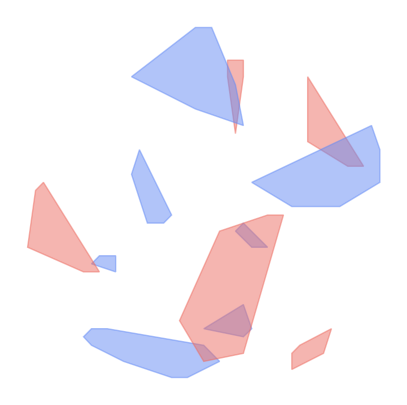

In [58]:
plt.figure(figsize=(5, 5))
plt.axis("off")

clusters = set(entities["cluster"].tolist())

print(clusters)

for counter, cluster in enumerate(clusters):

    points = []  # Points
    rows = entities.loc[entities["cluster"] == cluster]  # Rows

    for index, row in rows.iterrows():
        points.append([row["x"], row["y"]])
    points = np.array(points)

    print(len(points))

    hull = ConvexHull(points)  # Hull
    x_hull = np.append(points[hull.vertices, 0], points[hull.vertices, 0][0])
    y_hull = np.append(points[hull.vertices, 1], points[hull.vertices, 1][0])

    if cluster[0] == "p":
        plt.fill(x_hull, y_hull, "--", c="#ED6D62", alpha=0.5)  # Plot red
    elif cluster[0] == "n":
        plt.fill(x_hull, y_hull, "--", c="#648BF5", alpha=0.5)  # Plot blue


# Save

In [59]:
export = entities.copy()

export = export.drop(columns="years")
export = export.drop(columns="titles")
export = export.drop(columns="cooccurrences")


export.to_csv("src/data/entities.csv", index=False)

export.sample(1)


,name,type,frequency,slope,color,x,y,cluster,urls,frequency_norm,years_JSON
16,animals,subject,102,1.814828,#cccccc,445,281,-1,[https://www.forbes.com/sites/ceciliarodriguez...,0.105538,"{""2013"": 0, ""2015"": 0, ""2018"": 2, ""2019"": 19, ..."
